## HW11 数据分析及贝叶斯模型分类器
指导教师：胡俊峰

负责助教：苏亚鲁，李浩然

注意：仅需要提交.ipynb文件，请**不要**将下发压缩包中的其他文件一并交上。

截止日期：4月12日24点

### 第一部分：基础练习:用户观影数据分析（3分）

#### 1.1 用户偏好分析（3分）
    仿照课件中对pop_junk_movie的用户分析，分析pop_golden_movie的用户偏好情况，绘制图像并找到其中的非偏好人群的前3名。
    注：用户偏好通过根据用户数据中occ_desc项划分的不同用户群体的平均观影频率来反映，非偏好人群即平均观影频率较低的人群。

非偏好人群前三：retired，K-12 student，homemaker


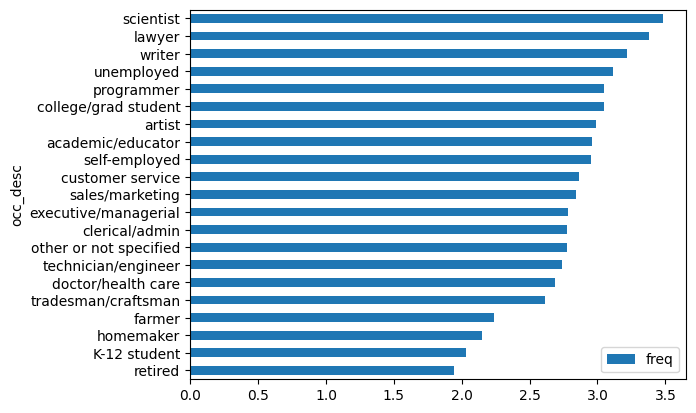

In [12]:
import numpy as np
import pandas as pd
import pylab as p

# Reading ratings file
ratings = pd.read_csv('data/ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('data/users.csv', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('data/movies.csv',  encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

ratings_movie_statis = ratings.groupby('movie_id').agg({'rating':'mean','user_id':'count'})
ratings_movie_statis.rename(columns={'rating':'rating_average','user_id':'user_count'}, inplace = True)
pop_golden_movies2 = ratings_movie_statis[(ratings_movie_statis['rating_average'] > 4.45) & (ratings_movie_statis['user_count']>500)]
golden_movies_users = ratings.merge(pop_golden_movies2, left_on ='movie_id', right_on = 'movie_id', how = 'inner')
golden_movies_users_distri = golden_movies_users.merge(users, left_on ='user_id', right_on = 'user_id', how = 'left')
show_distri = golden_movies_users_distri.groupby('occ_desc').agg({'movie_id':'count'})
user_occ_distri = users.groupby('occ_desc').agg({'user_id':'count'})
show_distri_freq = show_distri.merge(user_occ_distri, left_on ='occ_desc', right_on = 'occ_desc', how = 'inner')
show_distri_freq['freq'] = show_distri_freq['movie_id'] / show_distri_freq['user_id']
show_distri_freq.sort_values('freq',inplace = True)
show_distri_freq.plot.barh( y ='freq')
print('非偏好人群前三：{}，{}，{}'.format(*list(show_distri_freq.index[0:3])))

#### 1.2 对特定类型电影进行用户偏好分析（附加题，不占分）
    按照电影的类型进行拆分，并分析Comedy和Action两种类型电影的用户偏好。

非偏好人群前三：retired，technician/engineer，homemaker
非偏好人群前三：homemaker，retired，K-12 student


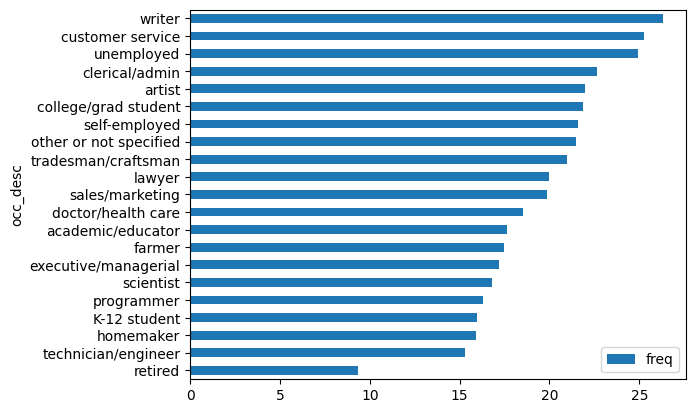

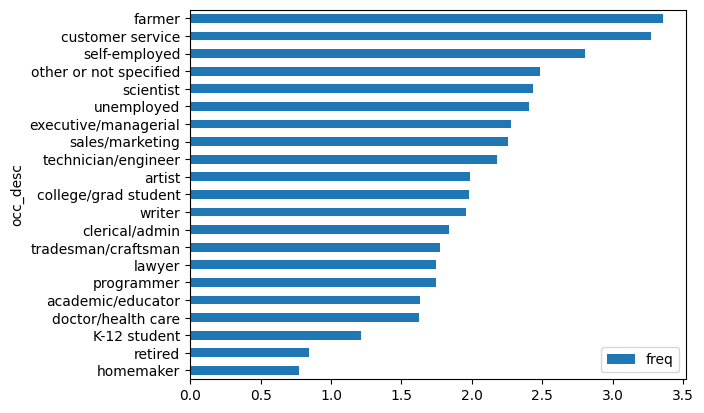

In [43]:
def show(mov_type):
    tp_movies = movies[movies.genres == mov_type]
    tp_movies_users = (ratings.merge(tp_movies, left_on ='movie_id', right_on = 'movie_id', how = 'inner')).merge(users, left_on ='user_id', right_on = 'user_id', how = 'left')
    show_distri = tp_movies_users.groupby('occ_desc').agg({'movie_id':'count'})
    user_occ_distri = users.groupby('occ_desc').agg({'user_id':'count'})
    show_distri_freq = show_distri.merge(user_occ_distri, left_on ='occ_desc', right_on = 'occ_desc', how = 'inner')
    show_distri_freq['freq'] = show_distri_freq['movie_id'] / show_distri_freq['user_id']
    show_distri_freq.sort_values('freq',inplace = True)
    show_distri_freq.plot.barh( y ='freq')
    print('非偏好人群前三：{}，{}，{}'.format(*list(show_distri_freq.index[0:3])))
show('Comedy')
show('Action')

### 第二部分：进阶练习（7分）
    使用贝叶斯模型来为用户推荐电影。

In [1]:
import numpy as np
import pandas as pd

# 读取 ratings 文件
ratings = pd.read_csv('data/ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])
# 使用全部数据填写数据矩阵，避免造成用户/电影的缺省
user_movie_matrix = ratings.pivot_table('rating', index='user_id', columns='movie_id', aggfunc='mean').fillna(0)
user_movie_matrix.shape

(6040, 3706)

In [2]:
import random
def transform(x):
    if x>2:
        return 1
    else:
        return 0
def mask(x):
    if x>0 and random.random() > 0.2:
        return x
    else:
        return 0

user_movie_matrix = user_movie_matrix.iloc[:,:].applymap(transform)  # 只有2分以上才认为有推荐的必要
train_data_matrix = user_movie_matrix.iloc[:,:].applymap(mask)  # 随机mask掉0.2的观影记录作为测试集
test_data_matrix = user_movie_matrix.subtract(train_data_matrix)  # 测试集

assert user_movie_matrix.values.reshape(1,-1).sum() == train_data_matrix.values.reshape(1,-1).sum() + test_data_matrix.values.reshape(1,-1).sum()

In [3]:
train_x = train_data_matrix.iloc[:,:]
train_y = train_data_matrix.iloc[:,:50]  # 由于电影数据过多，考虑时间问题，这里选取50部电影进行评测。
print(train_x.shape)
print(train_y.shape)
train_y.head()

(6040, 3706)
(6040, 50)


movie_id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [4]:
test_y = test_data_matrix.iloc[:,:50] # 由于电影数据过多，考虑时间问题，这里选取50部电影进行评测。
print(test_y.shape)
test_y.head()

(6040, 50)


movie_id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


#### 2.1 贝叶斯模型训练（3分）
    请根据朴素贝叶斯的后验概率公式分别计算先验概率和似然概率，并进行拉普拉斯平滑化。函数需要返回先验概率P和条件概率E。
    注：E[i]表示待预测电影有评分的前提下，其他各电影观看过的概率，即 P(x_i=1|c=1)

In [6]:
def train(X, Y):
    P,E = [],[]
    # TODO
    # X:(6040,3706), train_x
    # Y:(6040,50), train_y
    # P:(1, 50), P(y), list
    # E:(3706,50), [dataframe1(3706, 1), ...]
    for i in range(50):
        P.append(p_y:=np.sum(vecy:=Y.iloc[:,i])/6040)
        E.append(((vecy.T @ X + 1) / (p_y + 6040)).T)
    return P,E

#### 2.2 贝叶斯模型预测（4分）
    请根据2.1计算出的结果，使用train_x作为输入特征，计算待预测电影的后验概率，并为每个用户筛选出top-3电影和实际的观影记录比较，使用提供的代码进行评测。
    注：对于当前输入的特征（即观影记录），仅使用数值为1的特征值（即看过的电影）对应的条件概率和待预测电影的先验概率一起计算后验概率，数值为0的特征值不予考虑。

In [7]:
def predict(X,P,E) -> list:
    res = np.array([])
    for u in range(6040):
        p = [0] * 50
        for i in range(50):
            t = np.multiply(E[i].T,X.iloc[u,:])
            t = t[t!=0]
            p[i] = P[i] * np.prod(t)
        p = np.array(p)
        args = np.argsort(-p)[0:3]
        PreM = np.array([0]*50)
        for i in args: PreM[i] = 1
        res = np.r_[res, PreM]
    return list(res.flatten())

In [8]:
pre_list = []
P, E = train(train_x, train_y)
pre_list = predict(train_x, P, E)

In [9]:
y = (train_y+test_y).values.reshape(1,-1).tolist()[0]  # 实际观影记录
print(len(pre_list))
print(len(y))
assert len(pre_list) == len(y)

302000
302000


In [10]:
from sklearn.metrics import accuracy_score,classification_report
print(classification_report(y,pre_list))
print(accuracy_score(y,pre_list))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95    280198
           1       0.27      0.22      0.24     21802

    accuracy                           0.90    302000
   macro avg       0.60      0.59      0.60    302000
weighted avg       0.89      0.90      0.90    302000

0.9000264900662251
